In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    precision_recall_curve, average_precision_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [37]:
df = pd.read_csv("framingham.csv")
print(df.head(3))

# Selección de columnas
selected_cols = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 
                 'heartRate', 'cigsPerDay', 'TenYearCHD']
df_subset = df[selected_cols]
df_cleaned = df_subset.dropna()
print(f"Dimensiones del dataframe original: {df.shape[0]} filas, {df.shape[1]} columnas")
print(f"Dimensiones del dataframe después de borrar los datos faltantes: {df_cleaned.shape[0]} filas, {df_cleaned.shape[1]} columnas")

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   

   TenYearCHD  
0           0  
1           0  
2           0  
Dimensiones del dataframe original: 4240 filas, 16 columnas
Dimensiones del dataframe después de borrar los datos faltantes: 4142 filas, 8 columnas


In [38]:
def calcular_parametros(df_cleaned: pd.DataFrame, tau: float = 0.8):
    """
    Calcula n1, n2, n3, m1, m2, m3 y separa los dataframes por TenYearCHD.
    
    Parámetros:
    -----------
    df_cleaned : pd.DataFrame
        DataFrame ya limpio y con la columna TenYearCHD (valores 0 o 1).
    tau : float
        Parámetro de proporción (por defecto 0.8).
    
    Retorna:
    --------
    resultados : dict
        Diccionario con los valores n1, n2, n3, m1, m2, m3.
    df_chd_1 : pd.DataFrame
        Subconjunto con TenYearCHD = 1.
    df_chd_0 : pd.DataFrame
        Subconjunto con TenYearCHD = 0.
    """
    
    counts = df_cleaned['TenYearCHD'].value_counts()
    N1, N2 = counts[1], counts[0]

    # Cálculos
    n1 = int(np.ceil(tau * N1))
    n2 = int(tau * N2)
    n3 = int(np.floor((1 - tau) * (N1 + N2)))

    m1 = int(np.ceil(tau * min(N1, N2)))
    m2 = int(np.ceil(tau * min(N1, N2)))
    m3 = int(np.floor(2 * (1 - tau) * min(N1, N2)))

    # Separación de dataframes
    df_chd_1 = df_cleaned[df_cleaned['TenYearCHD'] == 1]
    df_chd_0 = df_cleaned[df_cleaned['TenYearCHD'] == 0]

    # Resultados en diccionario
    resultados = {"n1": n1, "n2": n2, "n3": n3, 
                  "m1": m1, "m2": m2, "m3": m3}

    # Mostrar resultados
    for k, v in resultados.items():
        print(f"{k}: {v}")

    return resultados, df_chd_1, df_chd_0

In [39]:
import numpy as np
import pandas as pd

# --- Asegura que df_cleaned ya existe y tiene la columna TenYearCHD (0/1) ---

# Subconjuntos por clase
df_chd_1 = df_cleaned[df_cleaned['TenYearCHD'] == 1].copy()
df_chd_0 = df_cleaned[df_cleaned['TenYearCHD'] == 0].copy()

# Conteos
N1 = len(df_chd_1)
N2 = len(df_chd_0)

# Parámetro
tau = 0.8

# Mismos cálculos que en R
n1 = int(np.ceil(tau * N1))
n2 = int(tau * N2)  # en R pusiste n2 <- tau*N2 (sin ceil/floor). En Python casteamos a int.
n3 = int(np.floor((1 - tau) * (N1 + N2)))

m1 = int(np.ceil(tau * min(N1, N2)))
m2 = int(np.ceil(tau * min(N1, N2)))
m3 = int(np.floor(2 * (1 - tau) * min(N1, N2)))

# Ajustes de seguridad para no pedir más de lo disponible
n1 = min(n1, N1)
n2 = min(n2, N2)

# Para proporcional-igual, m3 debe ser par y no exceder lo que queda tras el train proporcional
remain1 = N1 - n1
remain0 = N2 - n2
max_m3 = 2 * min(remain1, remain0)  
m3 = min(m3, max_m3)
if m3 % 2 == 1:
    m3 -= 1  # que sea par

print(f"N1={N1}, N2={N2}")
print(f"n1={n1}, n2={n2}, n3={n3}, m1={m1}, m2={m2}, m3={m3}")

N1=622, N2=3520
n1=498, n2=2816, n3=828, m1=498, m2=498, m3=248


In [40]:
# Uso de la función
resultados, df_chd_1, df_chd_0 = calcular_parametros(df_cleaned, tau=0.8)

n1: 498
n2: 2816
n3: 828
m1: 498
m2: 498
m3: 248


In [ ]:
def evaluar_modelo(model, X_train, y_train, X_test, y_test):
    """Entrena un modelo, calcula métricas y grafica curvas Precision-Recall."""
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else pred

    # ---Dimensiones---
    print(f"Dimensiones de X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"Dimensiones de X_test:  {X_test.shape},  y_test:  {y_test.shape}")

    # --- Matriz de confusión ---
    cm = confusion_matrix(y_test, pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap="Blues")
    plt.title("Matriz de Confusión")
    plt.show()

    # --- Métricas globales ---
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred)
    rec = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    # --- Curvas Precision-Recall por clase ---
    plt.figure(figsize=(6,5))

    for clase in [0, 1]:
        y_bin = (y_test == clase).astype(int)   # binarizamos la clase
        if hasattr(model, "predict_proba"):
            probas = model.predict_proba(X_test)[:, clase]
        else:
            probas = pred  # fallback para modelos sin probabilidad

        precision, recall, _ = precision_recall_curve(y_bin, probas)
        ap = average_precision_score(y_bin, probas)
        plt.plot(recall, precision, lw=2,
                 label=f"Clase {clase} (AP={ap:.2f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curvas Precision-Recall por clase")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {"confusion_matrix": cm, "accuracy": acc,
            "precision": prec, "recall": rec, "f1": f1}

# Proporcional

def proporcional(df_chd_1, df_chd_0, n1, n2, model=None, random_state=123):
    """
    Esquema 'proporcional':
    - Se toman n1 ejemplos de clase 1 y n2 ejemplos de clase 0 para entrenamiento.
    - El resto de las observaciones se usan como conjunto de prueba.
    
    Parámetros:
    -----------
    df_chd_1 : pd.DataFrame
        Subconjunto con TenYearCHD = 1.
    df_chd_0 : pd.DataFrame
        Subconjunto con TenYearCHD = 0.
    n1 : int
        Número de casos de clase 1 para entrenamiento.
    n2 : int
        Número de casos de clase 0 para entrenamiento.
    model : sklearn model, opcional
        Modelo a entrenar. Por defecto LogisticRegression.
    random_state : int
        Semilla para la selección aleatoria.

    Retorna:
    --------
    dict con métricas del modelo entrenado.
    """
    np.random.seed(random_state)

    idx1_train = np.random.choice(df_chd_1.index, size=n1, replace=False)
    idx0_train = np.random.choice(df_chd_0.index, size=n2, replace=False)

    df_train = pd.concat([df_chd_1.loc[idx1_train], df_chd_0.loc[idx0_train]])
    df_test  = pd.concat([df_chd_1.drop(idx1_train), df_chd_0.drop(idx0_train)])

    X_train, y_train = df_train.drop(columns="TenYearCHD"), df_train["TenYearCHD"]
    X_test, y_test   = df_test.drop(columns="TenYearCHD"), df_test["TenYearCHD"]

    if model is None:
        model = LogisticRegression(max_iter=1000)

    return evaluar_modelo(model, X_train, y_train, X_test, y_test)

#  Igual proporcional

def igual_proporcional(df_chd_1, df_chd_0, m1, m2, model=None, random_state=123):
    """
    Esquema 'igual-proporcional':
    - Se toman m1 ejemplos de clase 1 y m2 ejemplos de clase 0 para entrenamiento.
    - El resto de las observaciones se usan como conjunto de prueba.
    
    Parámetros:
    -----------
    df_chd_1 : pd.DataFrame
        Subconjunto con TenYearCHD = 1.
    df_chd_0 : pd.DataFrame
        Subconjunto con TenYearCHD = 0.
    m1 : int
        Número de casos de clase 1 para entrenamiento.
    m2 : int
        Número de casos de clase 0 para entrenamiento.
    model : sklearn model, opcional
        Modelo a entrenar. Por defecto LogisticRegression.
    random_state : int
        Semilla para la selección aleatoria.

    Retorna:
    --------
    dict con métricas del modelo entrenado.
    """
    np.random.seed(random_state)

    idx1_train = np.random.choice(df_chd_1.index, size=m1, replace=False)
    idx0_train = np.random.choice(df_chd_0.index, size=m2, replace=False)

    df_train = pd.concat([df_chd_1.loc[idx1_train], df_chd_0.loc[idx0_train]])
    df_test  = pd.concat([df_chd_1.drop(idx1_train), df_chd_0.drop(idx0_train)])

    X_train, y_train = df_train.drop(columns="TenYearCHD"), df_train["TenYearCHD"]
    X_test, y_test   = df_test.drop(columns="TenYearCHD"), df_test["TenYearCHD"]

    if model is None:
        model = LogisticRegression(max_iter=1000)

    return evaluar_modelo(model, X_train, y_train, X_test, y_test)

# Proporcional-igual

def proporcional_igual(df_chd_1, df_chd_0, n1, n2, m3, model=None, random_state=123):
    """
    Esquema 'proporcional-igual':
    - Se toman n1 ejemplos de clase 1 y n2 ejemplos de clase 0 para entrenamiento (proporcional).
    - El conjunto de prueba se balancea: m3/2 ejemplos de clase 1 y m3/2 de clase 0, 
      seleccionados de lo que quedó.
    
    Parámetros:
    -----------
    df_chd_1 : pd.DataFrame
        Subconjunto con TenYearCHD = 1.
    df_chd_0 : pd.DataFrame
        Subconjunto con TenYearCHD = 0.
    n1 : int
        Número de casos de clase 1 para entrenamiento.
    n2 : int
        Número de casos de clase 0 para entrenamiento.
    m3 : int
        Número total de casos para el test set (se divide en partes iguales entre clase 0 y 1).
    model : sklearn model, opcional
        Modelo a entrenar. Por defecto LogisticRegression.
    random_state : int
        Semilla para la selección aleatoria.

    Retorna:
    --------
    dict con métricas del modelo entrenado.
    """
    np.random.seed(random_state)

    # Entrenamiento proporcional
    idx1_train = np.random.choice(df_chd_1.index, size=n1, replace=False)
    idx0_train = np.random.choice(df_chd_0.index, size=n2, replace=False)

    df_chd_1_remain = df_chd_1.drop(idx1_train)
    df_chd_0_remain = df_chd_0.drop(idx0_train)

    # Test igualitario
    half_m3 = int(m3/2)
    idx1_test = np.random.choice(df_chd_1_remain.index, size=half_m3, replace=False)
    idx0_test = np.random.choice(df_chd_0_remain.index, size=half_m3, replace=False)

    df_train = pd.concat([df_chd_1.loc[idx1_train], df_chd_0.loc[idx0_train]])
    df_test  = pd.concat([df_chd_1_remain.loc[idx1_test], df_chd_0_remain.loc[idx0_test]])



    X_train, y_train = df_train.drop(columns="TenYearCHD"), df_train["TenYearCHD"]
    X_test, y_test   = df_test.drop(columns="TenYearCHD"), df_test["TenYearCHD"]

    if model is None:
        model = LogisticRegression(max_iter=1000)

    return evaluar_modelo(model, X_train, y_train, X_test, y_test)

# Igual igual 
def igual_igual(df_chd_1, df_chd_0, n1, m3, model=None, random_state=123):
    """
    Esquema 'igual-igual':
    - El conjunto de entrenamiento se balancea: se toman n1 ejemplos de clase 1 y 
      la misma cantidad (n1) de clase 0.
    - El conjunto de prueba también se balancea: se toman m3/2 ejemplos de clase 1 
      y m3/2 ejemplos de clase 0, a partir de los datos restantes.
    
    Parámetros:
    -----------
    df_chd_1 : pd.DataFrame
        Subconjunto con TenYearCHD = 1.
    df_chd_0 : pd.DataFrame
        Subconjunto con TenYearCHD = 0.
    n1 : int
        Número de casos de clase 1 para entrenamiento. La clase 0 usará la misma cantidad.
    m3 : int
        Número total de casos para el test set (se divide en partes iguales entre clase 0 y 1).
    model : sklearn model, opcional
        Modelo a entrenar. Por defecto LogisticRegression.
    random_state : int
        Semilla para la selección aleatoria.

    Retorna:
    --------
    dict con métricas del modelo entrenado.
    """
    np.random.seed(random_state)

    # Entrenamiento: mismo número de clase 0 y 1 (= n1)
    n1 = min(n1, len(df_chd_1))
    n0 = min(n1, len(df_chd_0))  # igualamos al tamaño de n1

    idx1_train = np.random.choice(df_chd_1.index, size=n1, replace=False)
    idx0_train = np.random.choice(df_chd_0.index, size=n0, replace=False)

    df_chd_1_remain = df_chd_1.drop(idx1_train)
    df_chd_0_remain = df_chd_0.drop(idx0_train)

    # Test: igual cantidad, m3/2 de cada clase
    half_m3 = int(m3/2)
    half_m3 = min(half_m3, len(df_chd_1_remain), len(df_chd_0_remain))

    idx1_test = np.random.choice(df_chd_1_remain.index, size=half_m3, replace=False)
    idx0_test = np.random.choice(df_chd_0_remain.index, size=half_m3, replace=False)

    df_train = pd.concat([df_chd_1.loc[idx1_train], df_chd_0.loc[idx0_train]])
    df_test  = pd.concat([df_chd_1_remain.loc[idx1_test], df_chd_0_remain.loc[idx0_test]])

    # Separar X e y
    X_train, y_train = df_train.drop(columns="TenYearCHD"), df_train["TenYearCHD"]
    X_test, y_test   = df_test.drop(columns="TenYearCHD"), df_test["TenYearCHD"]

    if model is None:
        model = LogisticRegression(max_iter=1000)

    return evaluar_modelo(model, X_train, y_train, X_test, y_test)



Dimensiones de X_train: (3314, 7), y_train: (3314,)
Dimensiones de X_test:  (828, 7),  y_test:  (828,)


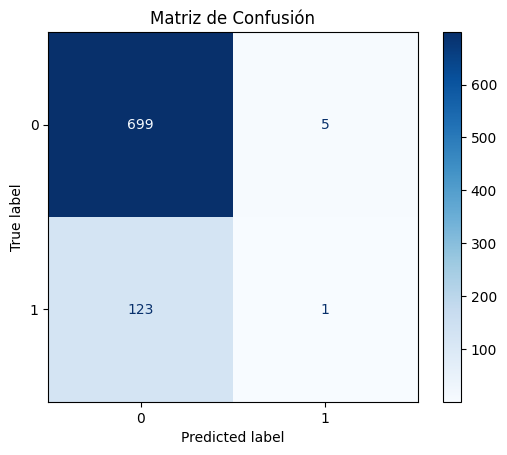

Accuracy:  0.8454
Precision: 0.1667
Recall:    0.0081
F1-Score:  0.0154


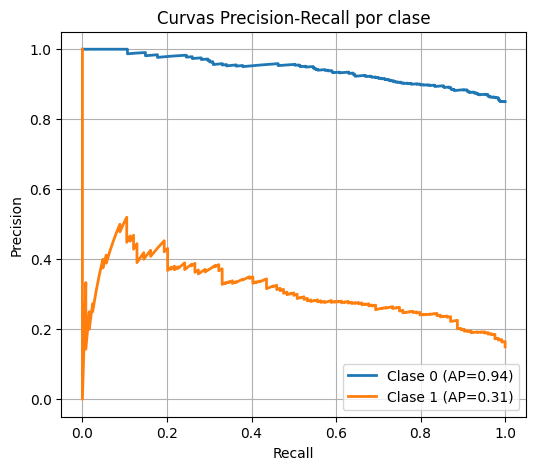

In [42]:
# Proporcional
res1 = proporcional(df_chd_1, df_chd_0, n1, n2)

Dimensiones de X_train: (996, 7), y_train: (996,)
Dimensiones de X_test:  (3146, 7),  y_test:  (3146,)


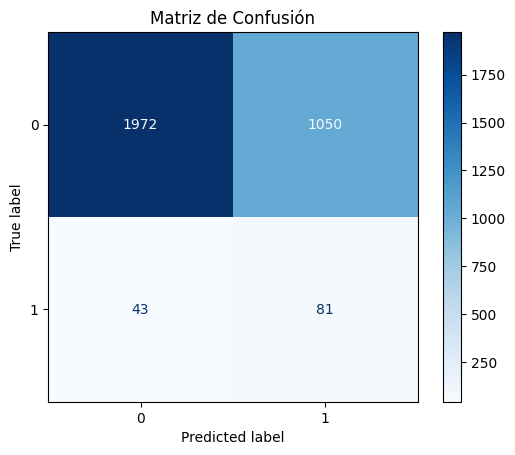

Accuracy:  0.6526
Precision: 0.0716
Recall:    0.6532
F1-Score:  0.1291


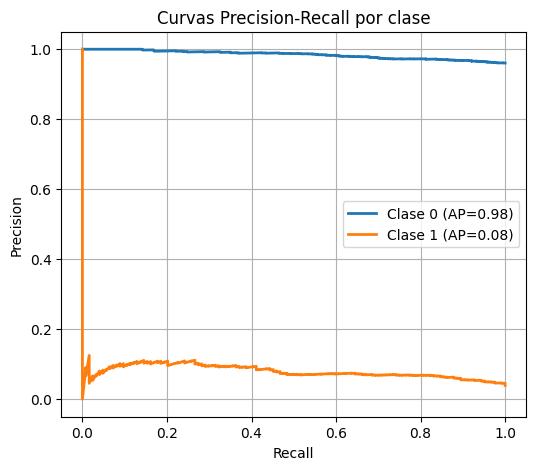

In [43]:
# Igual proporcional
res2 = igual_proporcional(df_chd_1, df_chd_0, m1, m2)

Dimensiones de X_train: (3314, 7), y_train: (3314,)
Dimensiones de X_test:  (248, 7),  y_test:  (248,)


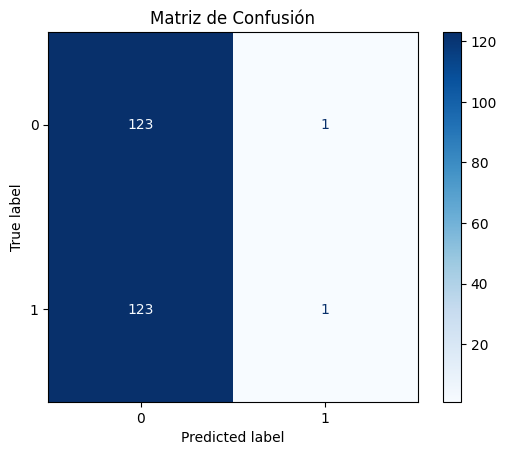

Accuracy:  0.5000
Precision: 0.5000
Recall:    0.0081
F1-Score:  0.0159


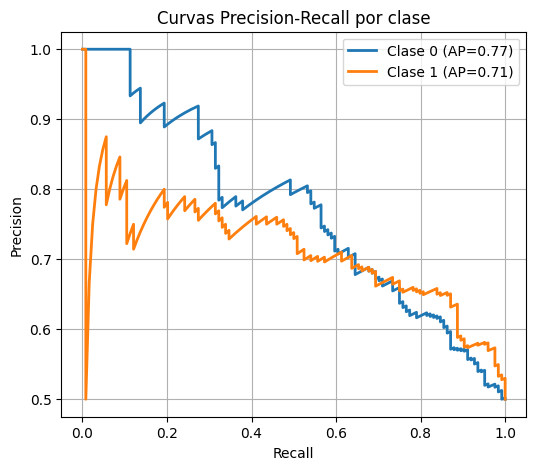

In [44]:
# Proporcional-igual
res3 = proporcional_igual(df_chd_1, df_chd_0, n1, n2, m3)

Dimensiones de X_train: (996, 7), y_train: (996,)
Dimensiones de X_test:  (248, 7),  y_test:  (248,)


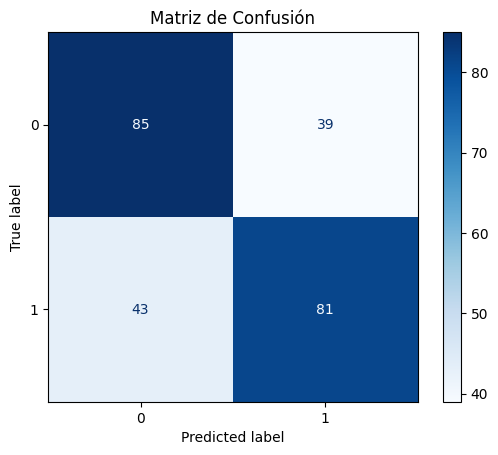

Accuracy:  0.6694
Precision: 0.6750
Recall:    0.6532
F1-Score:  0.6639


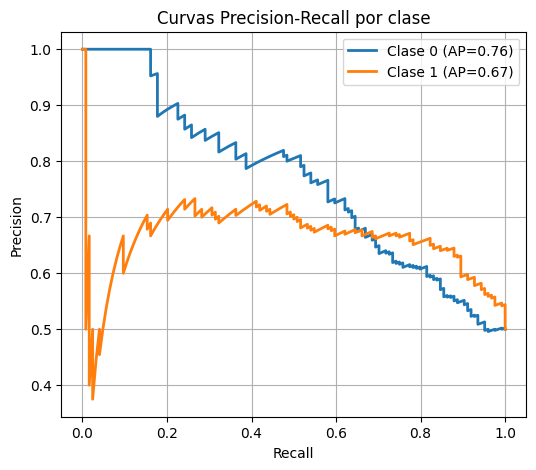

In [45]:
# igual-igual
res4 = igual_igual(df_chd_1, df_chd_0, n1, m3)